# Tranning AI

## Import libary

In [6]:
import numpy
import scipy.special
import matplotlib.pyplot
import imageio.v3
import glob
import math
from tqdm import tqdm

## Neural Network from scratch

In [7]:

# Enhanced neural network class definition with multiple hidden layers
class neuralNetwork:
    
    # initialise the neural network
    def __init__(self, inputnodes, hidden_layers, num_hidden_nodes, outputnodes, learningrate):
        """
        Initialize neural network with multiple hidden layers
        
        Args:
            inputnodes: number of input nodes
            hidden_layers: number of hidden layers
            num_hidden_nodes: number of nodes in each hidden layer (same for all)
            outputnodes: number of output nodes
            learningrate: learning rate for training
        """
        
        # ==================== NETWORK ARCHITECTURE SETUP ====================
        # Store the basic network configuration parameters
        self.inodes = inputnodes              # number of input nodes
        self.num_hidden_layers = hidden_layers    # number of hidden layers
        self.hnodes = num_hidden_nodes        # nodes per hidden layer
        self.onodes = outputnodes             # number of output nodes
        
        # Create complete layer configuration as a list
        # Format: [input_nodes, hidden_nodes, hidden_nodes, ..., output_nodes]
        # Example: [784, 10, 10, 10, ..., 10, 10] for 20 hidden layers of 10 nodes each
        self.layer_config = [inputnodes] + [num_hidden_nodes] * hidden_layers + [outputnodes]
        
        # ==================== WEIGHT MATRICES INITIALIZATION ====================
        # Initialize list to store all weight matrices between layers
        self.weights = []
        
        # Create weight matrices between each pair of consecutive layers
        # We need (total_layers - 1) weight matrices
        for i in range(len(self.layer_config) - 1):
            current_layer_nodes = self.layer_config[i]      # nodes in current layer
            next_layer_nodes = self.layer_config[i + 1]     # nodes in next layer
            
            # Initialize weights using normal distribution
            # Standard deviation = 1/sqrt(number of incoming connections)
            # This helps prevent vanishing/exploding gradients
            weight_matrix = numpy.random.normal(
                0.0,                                    # mean = 0
                pow(current_layer_nodes, -0.5),       # std = 1/sqrt(current_layer_nodes) 
                (next_layer_nodes, current_layer_nodes)    # shape: (next_layer × current_layer)
            )
            self.weights.append(weight_matrix)
        
        # ==================== TRAINING PARAMETERS ====================
        # Set learning rate for gradient descent
        self.lr = learningrate
        
        # ==================== ACTIVATION FUNCTION ====================
        # Define activation function (sigmoid function)
        # sigmoid(x) = 1 / (1 + e^(-x))
        # Output range: (0, 1)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
    # train the neural network using backpropagation
    def train(self, inputs_list, targets_list):
        
        # ==================== INPUT PREPARATION ====================
        # Convert input and target lists to 2D numpy arrays (column vectors)
        inputs = numpy.array(inputs_list, ndmin=2).T    # shape: (input_nodes, 1)
        targets = numpy.array(targets_list, ndmin=2).T   # shape: (output_nodes, 1)
        
        # ==================== FORWARD PROPAGATION ====================
        # Store outputs from each layer for use in backpropagation
        layer_outputs = [inputs]  # start with input layer output
        
        # Propagate signals forward through all layers
        for i, weight_matrix in enumerate(self.weights):
            # Calculate weighted sum of inputs to current layer
            # matrix multiplication: weights × previous_layer_output
            layer_inputs = numpy.dot(weight_matrix, layer_outputs[-1])
            
            # Apply activation function to get layer output
            if i <= len(self.weights) - 1:
                layer_output = self.activation_function(layer_inputs)
            else:
                layer_output = layer_inputs  # For output layer, we don't apply activation function
            
            # Store output for backpropagation
            layer_outputs.append(layer_output)
        
        # The final output is the output from the last layer
        final_outputs = layer_outputs[-1]
        
        # ==================== BACKWARD PROPAGATION (ERROR CALCULATION) ====================
        # Calculate errors for each layer (starting from output layer)
        # We'll store errors for each layer in the same order as layer_outputs
        layer_errors = [None] * len(layer_outputs)  # Initialize with None values
        
        # Output layer error: difference between target and actual output
        output_errors = targets - final_outputs
        layer_errors[-1] = output_errors  # Last layer (output) gets the output errors
        
        # Calculate errors for hidden layers (working backwards)
        # Error = (next_layer_weights^T) × (next_layer_errors)
        for i in range(len(self.weights) - 1, 0, -1):
            # i is the weight matrix index
            # self.weights[i] connects layer i to layer i+1
            # So we propagate error from layer i+1 back to layer i
            hidden_errors = numpy.dot(self.weights[i].T, layer_errors[i + 1])
            layer_errors[i] = hidden_errors
        
        # ==================== WEIGHT UPDATES (GRADIENT DESCENT) ====================
        # Update weights for all layers using gradient descent
        for i in range(len(self.weights)):
            # Get outputs from the layer before current weight matrix (input to weights[i])
            prev_layer_outputs = layer_outputs[i]
            
            # Get outputs and errors from the layer after current weight matrix (output from weights[i])
            current_layer_outputs = layer_outputs[i + 1]
            current_layer_errors = layer_errors[i + 1]
            
            # Calculate gradient using chain rule:
            # gradient = error × sigmoid_derivative × previous_layer_output
            # sigmoid_derivative = output × (1 - output)
            gradient = (current_layer_errors * current_layer_outputs * (1.0 - current_layer_outputs))
            
            # Update weights: new_weight = old_weight + learning_rate × gradient × input
            self.weights[i] += self.lr * numpy.dot(
                gradient,                           # error term with derivative
                numpy.transpose(prev_layer_outputs) # previous layer outputs (transposed)
            )
        
        pass
    
    # query the neural network (make predictions)
    def query(self, inputs_list):
        
        # ==================== INPUT PREPARATION ====================
        # Convert inputs list to 2D numpy array (column vector)
        inputs = numpy.array(inputs_list, ndmin=2).T    # shape: (input_nodes, 1)
        
        # ==================== FORWARD PROPAGATION ====================
        # Start with input layer output
        current_output = inputs
        
        # Propagate through all layers sequentially
        for i, weight_matrix in enumerate(self.weights):
            # Calculate weighted sum: weights × current_output
            layer_inputs = numpy.dot(weight_matrix, current_output)
            
            # Apply activation function to get next layer output
            if i <= len(self.weights) - 1:
                current_output = self.activation_function(layer_inputs)
            else:
                current_output = layer_inputs
        
        # Return final network output
        return current_output
    
    # utility method to print network architecture information
    def print_architecture(self):
        """
        Print detailed information about the network structure
        """
        print("Neural Network Architecture:")
        print(f"Input layer: {self.inodes} nodes")
        print(f"Hidden layers: {self.num_hidden_layers} layers, {self.hnodes} nodes each")
        print(f"Output layer: {self.onodes} nodes")
        print(f"Total layers: {len(self.layer_config)}")
        print(f"Total weight matrices: {len(self.weights)}")
        print(f"Learning rate: {self.lr}")

In [8]:
input_nodes = 784           # Input layer: 784 nodes (e.g., 28×28 pixel image)
hidden_layers = 5          # Number of hidden layers: 20
num_hidden_nodes = 64       # Nodes per hidden layer: 10 
output_nodes = 10           # Output layer: 10 nodes (e.g., digits 0-9)
learning_rate = 0.00075         # Learning rate for training

# Create instance of neural network
n = neuralNetwork(input_nodes, hidden_layers, num_hidden_nodes, output_nodes, learning_rate)

## Import tranning data

In [9]:
# load the mnist training data CSV files into lists
training_data_file1 = open("mnist_dataset/mnist_train.csv", 'r')
training_data_file2 = open("mnist_dataset/mnist_train_100.csv", 'r')
training_data_file3 = open("mnist_dataset/incorrect_images.csv", 'r')

training_data_list1 = training_data_file1.readlines()
training_data_list2 = training_data_file2.readlines()
training_data_list3 = training_data_file3.readlines()

training_data_file1.close()
training_data_file2.close()
training_data_file3.close()

# combine both lists
training_data_list = training_data_list1 + training_data_list2 + training_data_list3

## Tranning model

In [10]:
import numpy as np
from tqdm import tqdm

def calculate_loss(predictions, targets):
    L = targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions)
    return -np.mean(L)  
# Training configuration
epochs = 20
output_nodes = 10

for e in range(epochs):
    scorecard = []
    losses = []
    
    # Simple progress bar with accuracy and loss
    with tqdm(training_data_list, desc=f"Epoch {e+1}", unit="samples") as pbar:
        for record in pbar:
            all_values = record.split(',')
            correct_label = int(all_values[0]) 
            
            # Normalize inputs
            inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01

            # Make prediction
            outputs = n.query(inputs)
            predicted_label = np.argmax(outputs)
            
            # Create targets
            targets = np.zeros(output_nodes) + 0.01
            targets[correct_label] = 0.99
            
            # Calculate metrics
            is_correct = 1 if predicted_label == correct_label else 0
            scorecard.append(is_correct)
            loss = calculate_loss(outputs, targets)
            losses.append(loss)
            
            # Update progress bar with current accuracy and loss
            current_accuracy = (sum(scorecard) / len(scorecard)) * 100
            current_loss = np.mean(losses)
            
            pbar.set_postfix({
                'Acc': f'{current_accuracy:.2f}%',
                'Loss': f'{current_loss:.4f}'
            })
            
            # Train the network
            n.train(inputs, targets)

Epoch 20: 100%|██████████| 60108/60108 [11:02<00:00, 90.70samples/s, Acc=86.79%, Loss=0.6062] 


## Check performance of AI

In [11]:
# load the mnist test data CSV file into a list
test_data_file1 = open("mnist_dataset/mnist_test.csv", 'r')
test_data_file2 = open("mnist_dataset/mnist_test_10.csv", 'r')

# read all lines into a list
test_data_list1 = test_data_file1.readlines()
test_data_list2 = test_data_file2.readlines()

# close the files
test_data_file1.close()
test_data_file2.close()

# concatenate the two lists
test_data_list = test_data_list1 + test_data_list2


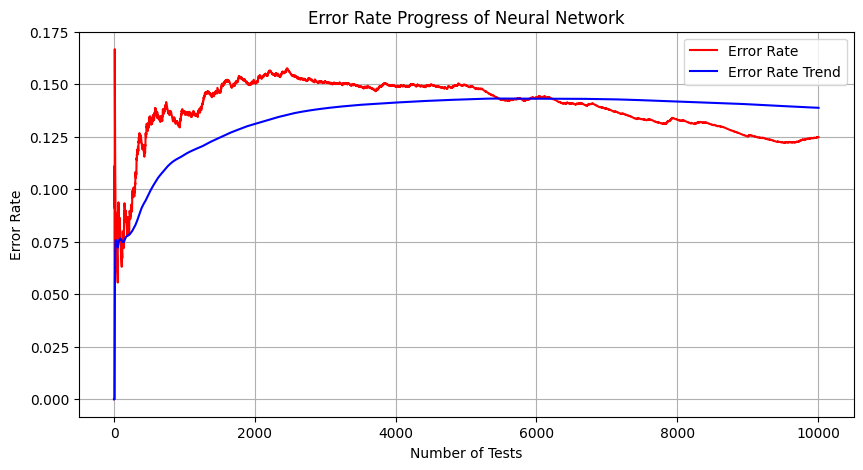

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# scorecard for how well the network performs, initially empty
scorecard = []

# list to store error rate after each test
error_progress = []
window_size = 10  # Kích thước cửa sổ trung bình động
error_trend = []

# go through all the records in the test data set
for i, record in enumerate(test_data_list):
    # split the record by the ',' commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    # scale and shift the inputs
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    # append correct or incorrect to list
    scorecard.append(1 if label == correct_label else 0)
    
    # calculate error rate after each test and store it
    error_rate = 1 - sum(scorecard) / len(scorecard)  # in percentage
    error_progress.append(error_rate)
    
    # Calculate cumulative moving average (trend line)
    trend_value = np.mean(error_progress)
    error_trend.append(trend_value)

# plot the error rate progress
plt.figure(figsize=(10, 5))
plt.plot(error_progress, color='red', label='Error Rate')
plt.plot(error_trend, color='blue', label='Error Rate Trend')
plt.xlabel("Number of Tests")
plt.ylabel("Error Rate")
plt.title("Error Rate Progress of Neural Network")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.8752247752247753


## Test 

In [34]:
from PIL import Image

import matplotlib.pyplot as plt
our_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob('t3.png'):
    
    # load image data and resize to 28x28 using PIL
    print("loading ...", image_file_name)
    img = Image.open(image_file_name).convert('L')  # convert to grayscale
    img_resized = img.resize((28, 28))  # resize to 28x28
    
    # convert image to numpy array
    img_array = numpy.array(img_resized).astype(float)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data to test data set
    our_own_dataset.append(img_data)

print("Dataset loaded with", len(our_own_dataset), "images")


loading ... t3.png
0.01
1.0
Dataset loaded with 1 images


[[0.00181989]
 [0.02849196]
 [0.80206933]
 [0.03466885]
 [0.03889796]
 [0.01240251]
 [0.0303789 ]
 [0.03453089]
 [0.02363345]
 [0.02370001]]
Predicted label:  2
Confidence: 80.21%


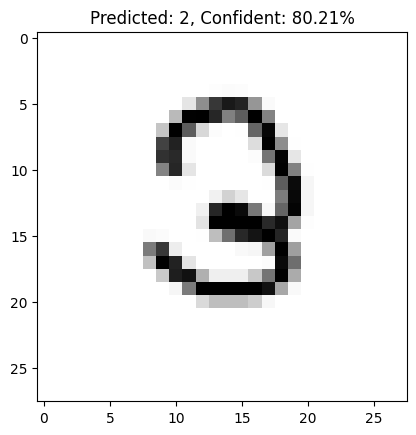

In [35]:
# test the neural network with our own images

# record to test
item = 0

# plot image
plt.imshow(our_own_dataset[item].reshape(28, 28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item]

# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("Predicted label: ", label)

confidence = outputs[label].item() * 100
print(f"Confidence: {confidence:.2f}%")

plt.title(f"Predicted: {label}, Confident: {confidence:.2f}%")
plt.show()


## Save ANN model

In [ ]:
import numpy as np

# Hàm lưu mô hình
def save_model(network, filename):
    # Lưu trọng số (weights) của mạng vào file
    np.save(filename + '_wih.npy', network.wih)  # Lưu trọng số từ input đến hidden layer
    np.save(filename + '_who.npy', network.who)  # Lưu trọng số từ hidden đến output layer
    print(f"Model saved to {filename}.")
save_model(n, 'my_model')